### Import Module

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


### Data Preprocessing

Augmentate for Training Data

In [20]:
# Augmentation for train set
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Val/Test: resize and normalize
val_test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [21]:
train_dataset = datasets.ImageFolder(root="PetImages_split/train", transform=train_transform)
val_dataset   = datasets.ImageFolder(root="PetImages_split/val", transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root="PetImages_split/test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [22]:
print("Number of train:", len(train_dataset))
print("Number of val:", len(val_dataset))
print("Number of test:", len(test_dataset))

Number of train: 17498
Number of val: 3748
Number of test: 3753


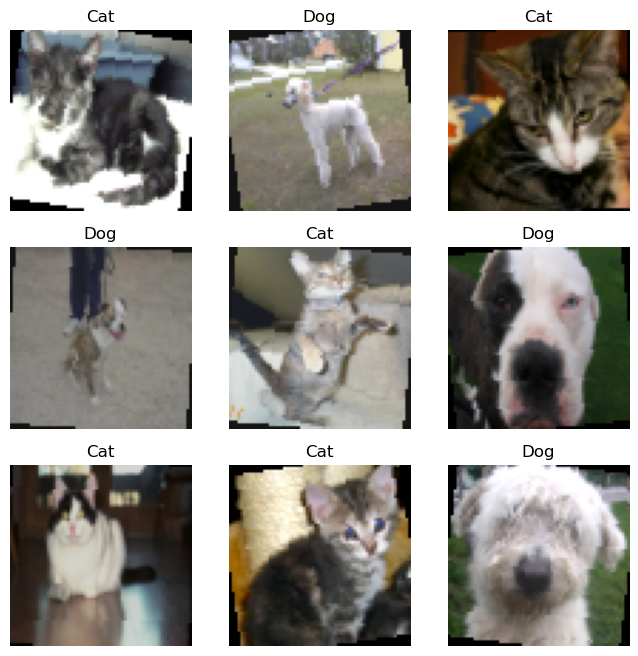

In [23]:
import matplotlib.pyplot as plt

classes = train_dataset.classes  # ['cat', 'dog']
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # đảo Normalize về [0,1]
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.show()


### CNN Model

Define CNN model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),        # thêm dropout để regularize
            nn.Linear(256, 2)       # 2 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x
model=CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=F

Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

num_epochs = 40
best_val_acc = 0.0

# Save result to plot later
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # ----------------- TRAIN -----------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ----------------- VALIDATION -----------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # ----------------- Save Process Result -----------------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # ----------------- PRINT -----------------
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # ----------------- SAVE BEST MODEL -----------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved best model with Val Acc: {val_acc:.2f}%")

c:\Users\acer\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/40], Train Loss: 0.9932, Train Acc: 55.89%, Val Loss: 0.6490, Val Acc: 61.98%
✅ Saved best model with Val Acc: 61.98%
Epoch [2/40], Train Loss: 0.6701, Train Acc: 57.18%, Val Loss: 0.6504, Val Acc: 60.33%
Epoch [3/40], Train Loss: 0.6626, Train Acc: 57.71%, Val Loss: 0.6614, Val Acc: 62.30%
✅ Saved best model with Val Acc: 62.30%
Epoch [4/40], Train Loss: 0.6504, Train Acc: 59.22%, Val Loss: 0.6188, Val Acc: 66.70%
✅ Saved best model with Val Acc: 66.70%
Epoch [5/40], Train Loss: 0.6367, Train Acc: 62.33%, Val Loss: 0.5996, Val Acc: 70.54%
✅ Saved best model with Val Acc: 70.54%
Epoch [6/40], Train Loss: 0.6227, Train Acc: 63.97%, Val Loss: 0.5999, Val Acc: 70.38%
Epoch [7/40], Train Loss: 0.6285, Train Acc: 61.08%, Val Loss: 0.5416, Val Acc: 73.77%
✅ Saved best model with Val Acc: 73.77%
Epoch [8/40], Train Loss: 0.6008, Train Acc: 65.76%, Val Loss: 0.5170, Val Acc: 76.28%
✅ Saved best model with Val Acc: 76.28%
Epoch [9/40], Train Loss: 0.5845, Train Acc: 67.85%, Val Loss: 0

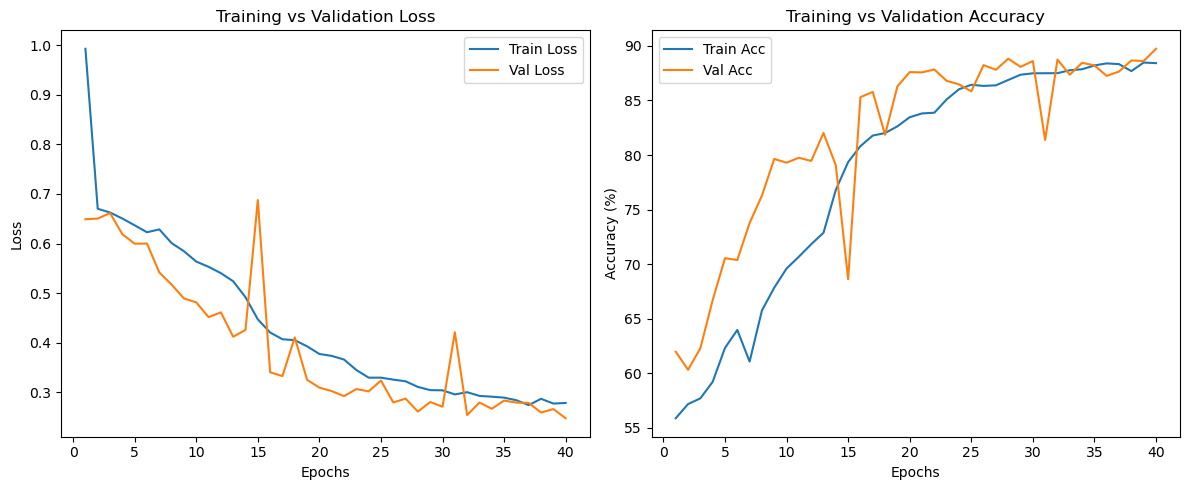

In [ ]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load best model saved during training
best_model = CNN()  # redefine the model structure
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.to(device)
best_model.eval()

#Evaluate function
def evaluate(model, loader, name="Val"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"{name} Accuracy: {100*correct/total:.2f}%")

# only evaluate on test set
evaluate(best_model, test_loader, "Test")


Test Accuracy: 89.40%


In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Dự đoán toàn bộ test set
all_preds = []
all_labels = []
best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Precision và recall cho từng lớp
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
for idx, cls in enumerate(classes):
    print(f"{cls} - Precision: {precision[idx]:.2f}, Recall: {recall[idx]:.2f}")

Confusion Matrix:
 [[1675  201]
 [ 197 1680]]
Cat - Precision: 0.89, Recall: 0.89
Dog - Precision: 0.89, Recall: 0.90


Evaluate Manual

In [ ]:
from PIL import Image

def predict_image(img_path, model, transform, classes, device):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # thêm batch dim
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
    return classes[predicted.item()]

# Ví dụ: test ảnh bất kỳ
result = predict_image("PetImages_split/test_new/pexels-valeriya-1805164.jpg", model, val_test_transform, classes, device)
print("Ảnh là:", result)

Ảnh là: Dog
